<a href="https://colab.research.google.com/github/crispitagorico/sigoptim/blob/main/mean_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classical mean variance optimisation

Let $P$ be a portfolio of assets $A_1,...,A_N$ with weights $\mathbf w = (w_1,...,w_N) \in \mathbb{R}^N$ and (random) returns $\mathbf r = (r_1,...,r_N) \in \mathbb{R}^N$. 

The portfolio total expected P&L is given by
$$\mathbf w^\top \mathbb E[\mathbf r] = \sum_{i=1}^N w_i \mathbb E[r_i].$$

Let $\Sigma = \mathbb E[(\mathbf r - \mathbb E[\mathbf r])(\mathbf r - \mathbb E[\mathbf r])^\top]$ be the covariance matrix of the returns.

The portfolio total risk is given by
$$\mathbf w^\top \Sigma \mathbf w = \sum_{i,j=1}^N w_i\Sigma_{i,j}w_j.$$

The mean-variance optimisation problem is formulated as follows
$$\min_{\mathbf w} \mathbf w^\top \Sigma \mathbf w \quad \text{ subject to } \ \mathbf w^\top \mathbb E[\mathbf r] = \mu, \quad \sum_{i=1}^Nw_i=1 \ \text{ and } \ 0 \leq w_i \leq 1,$$

where $\mu \in [0,\infty)$ is the expected P&L.

In [32]:
from itertools import product

import scipy 
import torch
import iisignature
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sym

from free_lie_algebra import *

In [3]:
def mean_variance_optim(expected_returns, covariance_matrix_returns, expected_pnl):

    # initialise weights
    N = expected_returns.size
    w0 = np.ones(N)

    # objective
    objective = lambda w: np.matmul(w.T, np.matmul(covariance_matrix_returns, w))

    # constraints
    bnds = tuple(N*[(0., 1.)])
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
            {'type': 'eq', 'fun': lambda w: np.matmul(w.T, expected_returns) - expected_pnl})

    # run optimisation
    optim = scipy.optimize.minimize(fun=objective, x0=w0, bounds=bnds, constraints=cons)

    # return optimal weights 
    return optim.x

In [4]:
# number of assets
N = 10
w_size = 40

# stocks
df      = pd.read_csv('stocks.csv', index_col=0)
names   = df.columns[:N].to_list()
prices  = df.iloc[-w_size:, :N].to_numpy()
returns = np.diff(prices, axis=0)/prices[:-1, :]

# expected returns
expected_returns = np.mean(returns, axis=0)

# covariance matrix of returns
covariance_matrix_returns = np.cov(returns, rowvar=False)

# expected portfolio returns
expected_pnls = np.linspace(-0.002, 0.02, 50)

# optimal weights for given expected returns
optimal_weights = [mean_variance_optim(expected_returns, covariance_matrix_returns, pnl) for pnl in expected_pnls]

# actual portfolio P&L
pnls = [np.matmul(w.T, expected_returns) for w in optimal_weights]

# portfolio risk
risks = [np.matmul(w.T, np.matmul(covariance_matrix_returns, w)) for w in optimal_weights]

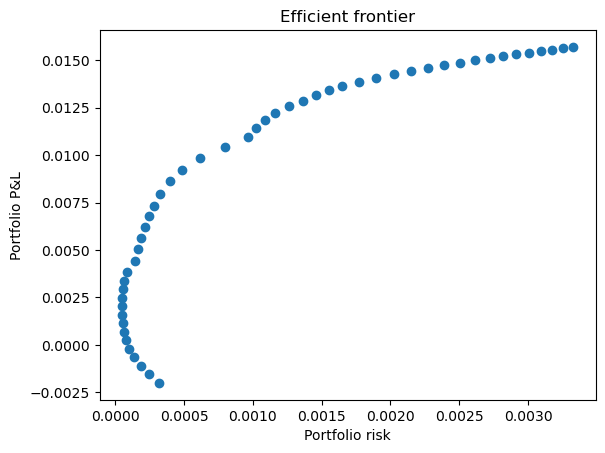

In [5]:
plt.scatter(risks, pnls)
plt.xlabel('Portfolio risk')
plt.ylabel('Portfolio P&L')
plt.title('Efficient frontier')
plt.show()

# Signature mean variance optimisation

Consider an $N$-dimensional price process $\mathbf S = (S^1,...,S^N) : [0,T] \to \mathbb{R}^N$. 

Consider $N$ linear functionals $\ell_i \in L(T^M(\mathbb{R}^N), \mathbb{R})$ for $i=1,...,N$ parameterised as

$$\ell_i = \sum_{|w| \leq M} \alpha^i_w w$$

Let $\ell = (\ell_1, ... ,\ell_N) \in L(T^M(\mathbb{R}^N), \mathbb{R}^N)$.

The expected P&L of a signature portfolio with weighting functional $\ell$ is given by

\begin{align}
\mathbb E \left[\int_0^T(\ell,S(X)_{0,t})^\top dX_t\right] &= \mathbb E \left[ \sum_{i=1}^N \int_0^T(\ell_i, S(X)_{0,t}) dX^i_t\right] \\
&= \mathbb E \left[ \sum_{i=1}^N \left(\ell_i \prec \mathbf i, S(X)_{0,T}\right)\right] \\
&= \sum_{i=1}^N \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)
\end{align}

where $\prec$ is the (right) half shuffle product (assuming paths start at $0$).

The portfolio total risk is given by

\begin{align}
& \mathbb E \left[\left(\int_0^T(\ell,S(X)_{0,t})^\top dX_t \right)^2\right] - \left(\mathbb E \left[\int_0^T(\ell,S(X)_{0,t})^\top dX_t \right]\right)^2\\
=& \ \mathbb E \left[ \sum_{i,j=1}^N \left(\ell_i \prec \mathbf i, S(X)_{0,T}\right)\left(\ell_j \prec \mathbf j, S(X)_{0,T}\right)\right] \\
& \quad - \sum_{i,j=1}^N  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right) \\
=&  \sum_{i,j=1}^N \left((\ell_i \prec \mathbf i) * (\ell_j \prec \mathbf j), \mathbb E \left[ S(X)_{0,T}\right]\right) -  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right)
\end{align}

where $*$ is the shuffle product.

The signature mean-variance optimisation problem is formulated as follows
$$\min_{\ell} \sum_{i,j=1}^N \left((\ell_i \prec \mathbf i) * (\ell_j \prec \mathbf j), \mathbb E \left[ S(X)_{0,T}\right]\right) -  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right)$$  

subject to 

$$\sum_{i=1}^N \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right) = \mu$$

where $\mu \in [0,\infty)$ is the expected P&L, and expected constraints

$$\sum_{i=1}^N \left(\ell_i, \mathbb E \left[S(X)_{0,t}\right]\right) = 1, \quad t \in [0,T]$$

and 
$$ 0< \left(\ell_i, \mathbb E \left[S(X)_{0,t}\right]\right) < 1, \quad t \in [0,T], \quad i=1,...,N$$

We first define utility functions to perform the optimisation.

In [7]:
# Helper functions
# utility

def make_linear_functional(coeffs, d, n_):
    linear_functional = 0.*word2Elt('')
    
    for i, w in enumerate(wordIter(d, n_)):
        linear_functional += coeffs[i]*word2Elt(w)
        
    return linear_functional

def ES(X, n_):
    """
    Calculates the expected signature associated to a bank of paths X, of shape N x l x d.
    
    :param X:  Bank of paths of shape N x l x d
    :param n_: Order of expected signature to take 
    
    :return:   Expected signature estimate of X
    
    """
    d     = X.shape[-1]
    sigX  = iisignature.sig(X, n_)
    esigX = np.array([1.] + list(np.mean(sigX, axis=0))) 
    return make_linear_functional(esigX, d, n_)

def make_ell_coeffs(N, n_, id_=""):
    prod_ = [i+1 for i in range(N)]
    
    a0    = ["a0" + id_]
    ais   = ['a' + ''.join(map(str, i)) + id_ for j in range(1, n+1) for i in product(prod_, repeat=j)]
    
    return sym.symbols(a0 + ais)

### Functions for the optimisation problem

# (l_i \preq i, S(X))
def integrate_linear_functional(ell, dim, sig):
    lpreqi = rightHalfShuffleProduct(ell, word2Elt(f'{dim+1}'))
    return dotprod(lpreqi, sig)

# (l_i, S(X)) 
def get_weight(ell, sig):
    return dotprod(ell, sig)

# \sum_{i=1}^N (l_i, S(X))
def sum_weights(ells, sig):
    w_sum = 0
    for ell in ells:
        w_sum += get_weight(ell, sig)
        
    return w_sum

# Returns (l_i \preq i) * (l_j \preq j)
def variance_linear_functional(ell1, ell2, dim1, dim2):
    lpreqi = rightHalfShuffleProduct(ell1, word2Elt(f'{dim1+1}'))
    lpreqj = rightHalfShuffleProduct(ell2, word2Elt(f'{dim2+1}'))
    
    return shuffleProduct(lpreqi, lpreqj)
                                     

# \sum_{i=1}^N (l_i \preq i, S(X))
def portfolio_return(ells, sig):
    mu = 0
    for dim, ell in enumerate(ells):
        mu += integrate_linear_functional(ell, dim, sig)
        
    return mu
    

def portfolio_variance(ells, sig):
    var = 0
    for dim1, ell1 in enumerate(ells):
        for dim2, ell2 in enumerate(ells):
            crossvar = dotprod(variance_linear_functional(ell1, ell2, dim1, dim2), sig)
            mean1    = integrate_linear_functional(ell1, dim1, sig)
            mean2    = integrate_linear_functional(ell2, dim2, sig)
            var     += crossvar - mean1*mean2
            
    return var
    

We now build our required functions and write these as symbolic expressions.

In [90]:
# Hyperparameters. Main one is the expected signature order to take (and thus on the linear functionals). 
# Since we take a shuffle product, the expected signature order will need to be 2 times this number.
n = 0

# We first define each of the l_i's
ell_coeffs  = [make_ell_coeffs(N, n, "^" + str(i+1)) for i in range(N)]
ells        = [make_linear_functional(ell_coeff, N, n) for ell_coeff in ell_coeffs]

# Build the expected signature (from data, for now). normalise prices to start at 0
#norm_prices =  prices - np.tile(np.expand_dims(prices[0], axis=0), (w_size, 1))
norm_prices = prices/prices[0] - 1
esig        = ES(np.expand_dims(norm_prices, 0), 2*(n+1))

# General wrapper to interface with scipy
def function_wrapper(func):
    def _wrapper(val):
        if len(val.shape) == 1:
            val = np.expand_dims(val, 1)
        return func(val)
    return _wrapper


# Lambdify optimising functional
variance_polynomial_ = portfolio_variance(ells, esig)
variance_polynomial  = sym.lambdify([ell_coeffs], variance_polynomial_)

@function_wrapper
def variance_function(a):
    return variance_polynomial(a)

# Need to lambdify constraints too 
return_polynomial_ = portfolio_return(ells, esig)
return_polynomial  = sym.lambdify([ell_coeffs], return_polynomial_)

weight_sum_polynomial_= sum_weights(ells, esig)
weight_sum_polynomial = sym.lambdify([ell_coeffs], weight_sum_polynomial_)

@function_wrapper
def return_function(a):
    return return_polynomial(a)

@function_wrapper
def weight_sum_function(a):
    return weight_sum_polynomial(a)

Optimiser for the signature mean-variance problem.

In [101]:
# Potentially you can pre-derive bounds on the weights?
def signature_mean_variance_optim(expected_pnl):
    N = np.array(ell_coeffs).shape[0]
    w0 = torch.ones(N).unsqueeze(1)/N

    #bnds = tuple(N*[(0., 1.)])
    cons = ({'type': 'eq', 'fun': lambda w: weight_sum_function(w) - 1.},
            {'type': 'eq', 'fun': lambda w: return_function(w) - expected_pnl})
    
    optim = scipy.optimize.minimize(fun=variance_function, x0=w0, constraints=cons)
    
    return optim.x

Build efficient frontier.

In [102]:
pnls     = np.linspace(0., 0.1, 50)

ellstars = [signature_mean_variance_optim(pnl) for pnl in pnls]

C:\Users\zacha\AppData\Local\Temp\ipykernel_12772\1383588388.py:10: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  optim = scipy.optimize.minimize(fun=variance_function, x0=w0, constraints=cons)
<lambdifygenerated-1>:3: RuntimeWarning: overflow encountered in double_scalars
  return 0.000577993990453182*Dummy_22**2 - 0.0044318057732841*Dummy_22*Dummy_23 + 0.000579225530092245*Dummy_22*Dummy_24 - 0.0120325799406786*Dummy_22*Dummy_25 - 0.001158721831201*Dummy_22*Dummy_26 + 0.0053242144339435*Dummy_22*Dummy_27 + 0.0158023074574621*Dummy_22*Dummy_28 + 0.00197882521232859*Dummy_22*Dummy_29 + 0.00169197627416016*Dummy_22*Dummy_31 - 0.00316110031767849*Dummy_23**2 + 0.00451011893183629*Dummy_23*Dummy_24 - 0.000572765721417035*Dummy_23*Dummy_25 - 0.0403485692227003*Dummy_23*Dummy_26 - 0.00413516706410645*Dummy_23*Dummy_27 + 0.0125605294410588*Dummy_23*Dummy_28 - 0